# Setup

In [ ]:
!pip install git+https://github.com/modAL-python/modAL.git
!pip install ipdb

In [ ]:
#@title import libraries
from google.colab import drive
import json
import os
import random
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import pdb
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from modAL.uncertainty import margin_sampling
from modAL.uncertainty import entropy_sampling
from skorch import NeuralNetClassifier
from skorch.callbacks import Callback
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import ToTensor
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from PIL import Image

# Utility Functions

In [ ]:
def get_value(input):
  #51  53  56  62  66  70  80  (85  86  87  88  89  90  91  92  93  94 95  96  98  99 100 101 104 105 106 109 110 111 112 113 114 117]
  if input in range(51,53): #empty
    return 1
  elif input in range(53,66): #enemy
    return 2
  elif input in range(66,80): #door
    return 3
  elif input in range (80,86): #key
    return 4
  elif input in range (88,92): #player
    return 6
  elif input in range (86,88) or (92,120): #wall
    return 5


# Mount Resources

In [ ]:
drive.mount('/content/drive')
# Define the border size
map_border = 60
tile_border = 0.5
# Define the tile size
tile_width = 60
tile_height = 60
distinct_values = [51,53,56,62,66,80,86,90,106]
#51 : empty, 53: enemy,bat, 56:enemy,scorpions, 62: enemy,spider, 66:door, 80:key, 86: wall, 90:player, 106: wall
#51 : empty, 53,56,62: enemy, 66:door, 80:key, 86,106: wall, 90:player



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title mounting playbale files
playable_levels = []
playable_levels_labels = []
for filename in os.listdir('/content/drive/MyDrive/Ghost Lab/levels/zelda/playable'):
    # Check if the file is an image
    if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
        # Open the image file
        img = Image.open(os.path.join('/content/drive/MyDrive/Ghost Lab/levels/zelda/playable', filename))
        tile_ints = []
        # Iterate over each tile in the tile map
        for y in range(0, 7):
          for x in range(0, 11):
            # Calculate the coordinates of the current tile in the tile map
            tile_x1 = map_border + x * (tile_width + 2*tile_border)
            tile_y1 = map_border + y * (tile_height + 2*tile_border)
            tile_x2 = tile_x1 + tile_width + 2*tile_border
            tile_y2 = tile_y1 + tile_height + 2*tile_border
            # Crop the border of the current tile
            tile_cropped = img.crop((tile_x1, tile_y1, tile_x2, tile_y2))
            # Convert the cropped tile image to grayscale and get the pixel values
            tile_gray = tile_cropped.convert('L')
            tile_pixels = list(tile_gray.getdata())
            # Convert the pixel values to an integer value
            tile_int = int(sum(tile_pixels) / len(tile_pixels))
            tile_ints.append(get_value(tile_int))
        if len(tile_ints) == 77:
          arr = np.array(tile_ints)
          # Reshape the array into a 2D array of size 7x11
          arr = np.array(tile_ints).reshape((7, 11))
          distinc = [1,2,3,4,5,6]
          matrix_dict = {val: (arr == val).astype(int) for val in distinc}
          for key in [1,2,3,4,5,6]:
            if key not in matrix_dict:
              matrix_dict[key] = np.zeros((7,11))

          # Convert the dictionary of counts to a NumPy array
          matrix_array = np.array([matrix_dict[val] for val in distinc])
          playable_levels.append(matrix_array)
          playable_levels_labels.append(1)

In [ ]:
#@title mounting unplaybale files
unplayable_levels = []
unplayable_levels_labels = []
for filename in os.listdir('/content/drive/MyDrive/Ghost Lab/levels/zelda/unplayable'):
    # Check if the file is an image
    if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
        # Open the image file
        img = Image.open(os.path.join('/content/drive/MyDrive/Ghost Lab/levels/zelda/unplayable', filename))
        tile_ints = []
        # Iterate over each tile in the tile map
        for y in range(0, 7):
          for x in range(0, 11):
            # Calculate the coordinates of the current tile in the tile map
            tile_x1 = map_border + x * (tile_width + 2*tile_border)
            tile_y1 = map_border + y * (tile_height + 2*tile_border)
            tile_x2 = tile_x1 + tile_width + 2*tile_border
            tile_y2 = tile_y1 + tile_height + 2*tile_border
            # Crop the border of the current tile
            tile_cropped = img.crop((tile_x1, tile_y1, tile_x2, tile_y2))
            # Convert the cropped tile image to grayscale and get the pixel values
            tile_gray = tile_cropped.convert('L')
            tile_pixels = list(tile_gray.getdata())
            # Convert the pixel values to an integer value
            tile_int = int(sum(tile_pixels) / len(tile_pixels))
            tile_int = int(sum(tile_pixels) / len(tile_pixels))
            tile_ints.append(get_value(tile_int))
        if len(tile_ints) == 77:
          arr = np.array(tile_ints)
          # Reshape the array into a 2D array of size 7x11
          arr = np.array(tile_ints).reshape((7, 11))
          distinc = [1,2,3,4,5,6]
          matrix_dict = {val: (arr == val).astype(int) for val in distinc}
          for key in [1,2,3,4,5,6]:
            if key not in matrix_dict:
              matrix_dict[key] = np.zeros((7,11))

          # Convert the dictionary of counts to a NumPy array
          matrix_array = np.array([matrix_dict[val] for val in distinc])
          unplayable_levels.append(matrix_array)
          unplayable_levels_labels.append(0)

In [ ]:
#@title balance the dataset
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler

playable_idx = np.random.choice(range(len(playable_levels)), size=5, replace=False)
unplayable_idx = np.random.choice(range(len(unplayable_levels)), size=5, replace=False)
initial_x = []
initial_y = []

for i in playable_idx:
  initial_x.append(playable_levels[i])
  initial_y.append(playable_levels_labels[i])

for i in unplayable_idx:
  initial_x.append(unplayable_levels[i])
  initial_y.append(unplayable_levels_labels[i])



levels = []
levels.extend(playable_levels)
levels.extend(unplayable_levels)
levels = np.array(levels)
print(levels.shape)

labels = []
labels.extend(playable_levels_labels)
labels.extend(unplayable_levels_labels)
labels = np.array(labels)
print(labels.shape)

initial_x = np.array(initial_x)
print(initial_x.shape)
initial_y = np.array(initial_y)
print(initial_y.shape)

print('the overal shape of X dataset: ' + str(levels.shape))
print('the overal shape of Y dataset: ' + str(labels.shape))

(2048, 6, 7, 11)
(2048,)
(10, 6, 7, 11)
(10,)
the overal shape of X dataset: (2048, 6, 7, 11)
the overal shape of Y dataset: (2048,)


# Model

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

class ResNet18Custom(nn.Module):
    def __init__(self, num_channels=6, num_classes=2):
        super(ResNet18Custom, self).__init__()
        self.resnet = models.resnet18()
        self.resnet.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.fc = nn.Linear(512, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.resnet(x)
        #x = self.sigmoid(x)
        x = F.softmax(x, dim=1)
        return x
        #x = self.resnet(x)
        #x = self.resnet.conv1(x)
        #x = self.resnet.fc(x)
        #return x

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.conv1 = nn.Conv2d(6, 16, kernel_size=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=1)
        self.relu3 = nn.ReLU()

        self.fc1 = nn.Linear(128, 32)
        self.relu4 = nn.ReLU()

        self.fc2 = nn.Linear(32, 2)
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu3(x)

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = self.relu4(x)

        x = self.fc2(x)
        x = self.softmax(x)

        return x

import torch.nn as nn

class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()

        self.fc1 = nn.Linear(6*7*11, 128)
        self.relu1 = nn.ReLU()

        self.fc2 = nn.Linear(128, 256)
        self.relu2 = nn.ReLU()

        self.fc3 = nn.Linear(256, 1024)
        self.relu3 = nn.ReLU()

        self.fc4 = nn.Linear(1024, 32)
        self.relu4 = nn.ReLU()

        self.fc5 = nn.Linear(32, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.relu1(x)

        x = self.fc2(x)
        x = self.relu2(x)

        x = self.fc3(x)
        x = self.relu3(x)

        x = self.fc4(x)
        x = self.relu4(x)

        x = self.fc5(x)
        x = self.softmax(x)

        return x


# Passive Learner

410
1638
Validation fold 1, epoch 1: train_loss = 2.55
Fold 1: val_loss = 0.69, val_acc = 0.59
Validation fold 1, epoch 2: train_loss = 2.54
Fold 1: val_loss = 0.69, val_acc = 0.59
Validation fold 1, epoch 3: train_loss = 2.54
Fold 1: val_loss = 0.69, val_acc = 0.59
Validation fold 1, epoch 4: train_loss = 2.53
Fold 1: val_loss = 0.69, val_acc = 0.59
Validation fold 1, epoch 5: train_loss = 2.49
Fold 1: val_loss = 0.69, val_acc = 0.59
Validation fold 1, epoch 6: train_loss = 2.42
Fold 1: val_loss = 0.71, val_acc = 0.41
Validation fold 1, epoch 7: train_loss = 2.02
Fold 1: val_loss = 0.93, val_acc = 0.50
Validation fold 1, epoch 8: train_loss = 1.56
Fold 1: val_loss = 1.28, val_acc = 0.41
Validation fold 1, epoch 9: train_loss = 1.20
Fold 1: val_loss = 1.28, val_acc = 0.41
Validation fold 1, epoch 10: train_loss = 1.13
Fold 1: val_loss = 1.29, val_acc = 0.40
Validation fold 1, epoch 11: train_loss = 0.92
Fold 1: val_loss = 1.39, val_acc = 0.45
Validation fold 1, epoch 12: train_loss = 0

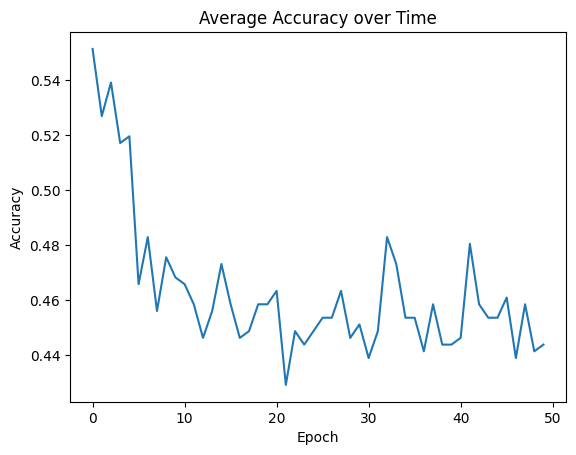

Execution time of: 23.945706844329834 seconds


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import time
import pickle
import ipdb

def encode_labels(labels):
    if not isinstance(labels, torch.Tensor) or labels.dtype != torch.float32:
        raise ValueError("Input must be a PyTorch tensor of float32 dtype.")
    if labels.ndim != 1 or not torch.all(torch.logical_or(labels == 0, labels == 1)):
        raise ValueError("Input must be a 1D PyTorch tensor of 0s and 1s.")
    encoded_labels = torch.zeros((len(labels), 2), dtype=torch.float32)
    encoded_labels[torch.where(labels == 0)[0], 0] = 1
    encoded_labels[torch.where(labels == 1)[0], 1] = 1
    return encoded_labels

X_tensor = torch.FloatTensor(levels)
y_tensor = torch.FloatTensor(labels)
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset = torch.utils.data.TensorDataset(torch.tensor(X_tensor).to(device), torch.tensor(y_tensor).to(device))
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

print(len(test_data))
print(len(train_data))

num_folds = 5
num_epochs = 50
weight_decay=1e-3 # reasonale 1e-4 to 1e-2.
learning_rate = 1e-2 # reasonable 1e-4 and 0.1

kf = KFold(n_splits=num_folds, shuffle=True)

all_true_labels = []
all_pred_labels = []
all_fold_acc_history = []
start_time = time.time()

for fold, (train_indices, val_indices) in enumerate(kf.split(test_data)):
    model = Model2()
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=weight_decay)

    train_fold_data = torch.utils.data.Subset(train_data, train_indices)
    val_fold_data = torch.utils.data.Subset(test_data, val_indices)
    train_fold_loader = torch.utils.data.DataLoader(train_fold_data, batch_size=32, shuffle=True)
    val_fold_loader = torch.utils.data.DataLoader(val_fold_data, batch_size=32, shuffle=False)

    fold_acc_history = []
    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        for inputs, labels in train_fold_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            #ipdb.set_trace()
            loss = criterion(outputs, encode_labels(labels))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(val_fold_loader)
        print(f"Validation fold {fold + 1}, epoch {epoch + 1}: train_loss = {train_loss:.2f}")

        with torch.no_grad():
            model.eval()
            val_loss = 0
            val_acc = 0
            true_labels = []
            pred_labels = []
            for inputs, labels in val_fold_loader:
                outputs = model(inputs)
                loss = criterion(outputs, encode_labels(labels))
                val_loss += loss.item()
                y_pred = np.argmax(outputs, axis=1)
                true_labels += labels.tolist()
                pred_labels += y_pred.round().tolist()
            val_loss /= len(val_fold_loader)

        val_acc = accuracy_score(true_labels, pred_labels)
        fold_acc_history.append(val_acc)
        print(f"Fold {fold + 1}: val_loss = {val_loss:.2f}, val_acc = {val_acc:.2f}")
    all_fold_acc_history.append(fold_acc_history)
    all_true_labels += true_labels
    all_pred_labels += pred_labels

# Compute the overall confusion matrix and accuracy
overall_cm = confusion_matrix(all_true_labels, all_pred_labels)
overall_acc = accuracy_score(all_true_labels, all_pred_labels)

# Print the overall confusion matrix and accuracy
print(f"Overall confusion matrix:\n{overall_cm}")
print(f"Overall accuracy: {overall_acc:.2f}")

# Compute the average accuracy over all folds for each epoch
mean_acc_history = [sum([fold_acc_history[i] for fold_acc_history in all_fold_acc_history])/num_folds for i in range(len(all_fold_acc_history[0]))]

# Plot the average accuracy over all folds over time
plt.plot(mean_acc_history)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Average Accuracy over Time')
plt.show()
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time of: {execution_time} seconds")

from datetime import datetime
timestamp = str(int(time.time()))  # Obtain the current timestamp
torch.save(model.state_dict(), '/content/drive/MyDrive/Ghost Lab/cog 2023/camera-ready/Zelda-data/passive/model_'+timestamp+'_.h5')

json_object = json.dumps({
    'folds' : num_folds, 'epochs' : num_epochs,
    'weight_decay' : weight_decay, 'learning_rate': learning_rate,
    'execution_time' : execution_time}, indent=4)
with open('/content/drive/MyDrive/Ghost Lab/cog 2023/camera-ready/Zelda-data/passive/parameters-'+timestamp+'.json', 'w') as outfile:
    outfile.write(json_object)

with open('/content/drive/MyDrive/Ghost Lab/cog 2023/camera-ready/Zelda-data/passive/parameters-'+timestamp+'.pickle', 'wb') as handle:
    pickle.dump(
        {'all_fold_acc_history' : all_fold_acc_history,'confusion' : overall_cm}
        , handle)

# Active Learner

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import pdb
import math
import time
from datetime import datetime

#random_query_strategy
#margin_sampling
#entropy_sampling
#uncertainty_sampling

def random_query_strategy(classifier, X, n_instances=1):
    indices = list(range(len(X)))
    random.shuffle(indices)
    return indices[:n_instances]

#random_query_strategy
#margin_sampling
#entropy_sampling
#uncertainty_sampling

def train_active_learner(strategy, n_queries, n_instances, max_epochs, fraction):
    num_folds = 5
    num_rounds = 5
    all_fold_acc_history = []
    all_fold_false_positives = []
    all_fold_false_negatives = []
    # initial training dataset
    X_tensor = torch.FloatTensor(levels)
    y_tensor = torch.LongTensor(labels)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    dataset = torch.utils.data.TensorDataset(torch.tensor(X_tensor).to(device), torch.tensor(y_tensor).to(device))
    dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))
    X , y = next(iter(dataset_loader))
    X = X.detach().cpu().numpy()
    y = y.detach().cpu().numpy()
    #
    X_ini = torch.FloatTensor(initial_x)
    y_ini = torch.LongTensor(initial_y)
    ini_dataset = torch.utils.data.TensorDataset(torch.tensor(X_ini).to(device), torch.tensor(y_ini).to(device))
    ini_loader = torch.utils.data.DataLoader(ini_dataset, batch_size=len(ini_dataset))
    X_0 , y_0 = next(iter(ini_loader))
    X_0 = X_0.detach().cpu().numpy()
    y_0 = y_0.detach().cpu().numpy()

    kf = KFold(n_splits=num_folds, shuffle=True)

    start_time = time.time()
    for fold, (train_indices, val_indices) in enumerate(kf.split(dataset)):
        X_train = X[train_indices]
        X_test= X[val_indices]
        y_train = y[train_indices]
        y_test = y[val_indices]

        print(f"Fold no {fold+1}")
        # 5 trials
        rounds_accuracies = []
        rounds_fps = []
        rounds_fns = []
        for round in range (0,num_rounds):
            print(f"Fold no {fold+1} . Round no {round+1}")
            this_round_accuracies = []
            this_round_fps = 0
            this_round_fns = 0
            classifier = NeuralNetClassifier(Model, criterion=nn.CrossEntropyLoss,
                                 optimizer=torch.optim.Adam, optimizer__weight_decay=0.001,
                                 max_epochs = max_epochs, train_split=None,
                                 verbose=0, device=device, warm_start = True,)
            learner = ActiveLearner(estimator=classifier,X_training=X_0, y_training=y_0,query_strategy=strategy)
            y_pred = learner.predict(X_test)
            ini_acc = accuracy_score(y_test, y_pred)
            print(ini_acc)
            fold_acc_history = []
            for idx in range(n_queries):
                random_indices = np.random.choice(range(len(X_train)), size=math.floor(fraction*len(X_train)), replace=False)
                query_idx, query_instance = learner.query(X_train[random_indices], n_instances=n_instances)
                x_query = X_train[query_idx]
                y_query = y_train[query_idx]
                learner.teach(X=x_query, y=y_query)
                y_pred = learner.predict(X_test)

                true_labels = y_test.tolist()
                pred_labels = y_pred.tolist()
                for kk in range(len(true_labels)):
                    if (pred_labels[kk] == 1) & (true_labels[kk] == 0):
                        this_round_fps += 1
                    if (pred_labels[kk] == 0) & (true_labels[kk] == 1):
                        this_round_fns += 1

                val_acc = accuracy_score(y_test, y_pred)
                this_round_accuracies.append(val_acc)

                X_train = np.delete(X_train, query_idx, axis=0)
                y_train = np.delete(y_train, query_idx, axis=0)
                print(f"Fold no {fold+1} . Round no {round+1} . Query no {idx+1}: Acc = {val_acc:.2f}")
            rounds_accuracies.append(this_round_accuracies)
            rounds_fps.append(this_round_fps)
            rounds_fns.append(this_round_fns)
        all_rounds_mean_accuracy = np.mean(rounds_accuracies, axis=0)
        all_fold_acc_history.append(all_rounds_mean_accuracy)

        all_rounds_fps = np.mean(rounds_fps)
        all_rounds_fns = np.mean(rounds_fns)
        all_fold_false_positives.append(all_rounds_fps)
        all_fold_false_negatives.append(all_rounds_fns)

        print(f"Fold no {fold+1} . ALL ACC = {all_rounds_mean_accuracy}: total:{len(y_test)} : fps:{all_fold_false_positives} : nps:{all_fold_false_negatives}")
        timestamp = str(int(time.time()))  # Obtain the current timestamp
        with open('/content/drive/MyDrive/Ghost Lab/cog 2023/camera-ready/Zelda-data/active/model_fold'+str(fold+1)+'-'+timestamp+'.pickle', 'wb') as handle:
            pickle.dump(classifier, handle)

    end_time = time.time()
    execution_time = end_time - start_time

    return  classifier, all_fold_acc_history , execution_time, all_fold_false_positives, all_fold_false_negatives



In [ ]:
#@title Margin Sampling
import pickle

STRATEGY = margin_sampling
N_INSTANCES = 1
N_QUERIES = 100
MAX_EPOCHS = 50
FRACTION = 0.6
np.random.seed(75)  # Set the seed value to 42

# Define the size of the level
width = 29
height = 13
levels = []
levels.extend(playable_levels)
levels.extend(unplayable_levels)
levels = np.array(levels)
print(levels.shape)

labels = []
labels.extend(playable_levels_labels)
labels.extend(unplayable_levels_labels)
labels = np.array(labels)
print(labels.shape)

classifier_1, all_fold_acc_history_1, execution_time_1, fps_1,fns_1= train_active_learner(STRATEGY, N_QUERIES, N_INSTANCES,MAX_EPOCHS, FRACTION)

print(f"Execution time: {execution_time_1} seconds")

print(fps_1)
print(fns_1)

# Calculate average accuracy and standard error for each epoch
mean_accuracy_1 = np.mean(all_fold_acc_history_1, axis=0)
std_error_1 = np.std(all_fold_acc_history_1, axis=0) / np.sqrt(len(all_fold_acc_history_1))
std_dev_1 = np.std(all_fold_acc_history_1, axis=0)
# Plotting
epochs_1 = range(1, len(mean_accuracy_1) + 1)
# Calculate upper and lower bounds for the fill region
lower_bound_1 = mean_accuracy_1 - std_dev_1
upper_bound_1 = mean_accuracy_1 + std_dev_1

plt.errorbar(epochs_1, mean_accuracy_1, yerr=std_error_1, capsize=3)
plt.xlabel('Queries')
plt.ylabel('Accuracy')
plt.title('Average Accuracy over Epoch with Standard Error')
plt.show()

plt.plot(epochs_1, mean_accuracy_1, label='Average Accuracy')
plt.fill_between(epochs_1, lower_bound_1, upper_bound_1, alpha=0.3, label='Standard Deviation')
plt.xlabel('Queries')
plt.ylabel('Accuracy')
plt.title('Average Accuracy over Queries with Standard Deviation')
plt.legend()
plt.show()

from datetime import datetime
timestamp = str(int(time.time()))  # Obtain the current timestamp
with open('/content/drive/MyDrive/Ghost Lab/cog 2023/camera-ready/Zelda-data/active/model_'+timestamp+'.pickle', 'wb') as handle:
    pickle.dump(classifier_1, handle)

json_object = json.dumps({
    'STRATEGY' : 'margin_sampling', 'num_instances' : N_INSTANCES,
    'num_queries' : N_QUERIES, 'epochs' : MAX_EPOCHS,
    'fraction': FRACTION,
    'weight_decay' : 0.001, 'learning_rate': '?',
    'execution_time' : execution_time_1}, indent=4)
with open('/content/drive/MyDrive/Ghost Lab/cog 2023/camera-ready/Zelda-data/active/parameters-'+timestamp+'.json', 'w') as outfile:
    outfile.write(json_object)

with open('/content/drive/MyDrive/Ghost Lab/cog 2023/camera-ready/Zelda-data/active/results-'+timestamp+'.pickle', 'wb') as handle:
    pickle.dump({'all_fold_acc_history' : all_fold_acc_history_1,'fps' : fps_1, 'fns': fns_1}, handle)


In [ ]:
#@title Random Sampling
STRATEGY = random_query_strategy
N_INSTANCES = 1
N_QUERIES = 100
MAX_EPOCHS = 20
FRACTION = 0.55
np.random.seed(30)  # Set the seed value to 42

# Define the size of the level
width = 29
height = 13
levels = []
levels.extend(playable_levels)
levels.extend(unplayable_levels)
levels = np.array(levels)
print(levels.shape)

labels = []
labels.extend(playable_levels_labels)
labels.extend(unplayable_levels_labels)
labels = np.array(labels)
print(labels.shape)

classifier_2, all_fold_acc_history_2, execution_time_2, fps_2,fns_2= train_active_learner(STRATEGY, N_QUERIES, N_INSTANCES,MAX_EPOCHS, FRACTION)

print(f"Execution time: {execution_time_1} seconds")

print(fps_2)
print(fns_2)

# Calculate average accuracy and standard error for each epoch
mean_accuracy_2 = np.mean(all_fold_acc_history_2, axis=0)
std_error_2 = np.std(all_fold_acc_history_2, axis=0) / np.sqrt(len(all_fold_acc_history_2))
std_dev_2 = np.std(all_fold_acc_history_2, axis=0)
# Plotting
epochs_2 = range(1, len(mean_accuracy_2) + 1)
# Calculate upper and lower bounds for the fill region
lower_bound_2 = mean_accuracy_2 - std_dev_2
upper_bound_2 = mean_accuracy_2 + std_dev_2

plt.errorbar(epochs_2, mean_accuracy_2, yerr=std_error_2, capsize=3)
plt.xlabel('Queries')
plt.ylabel('Accuracy')
plt.title('Average Accuracy over Epoch with Standard Error')
plt.show()

plt.plot(epochs_2, mean_accuracy_2, label='Average Accuracy')
plt.fill_between(epochs_2, lower_bound_2, upper_bound_2, alpha=0.3, label='Standard Deviation')
plt.xlabel('Queries')
plt.ylabel('Accuracy')
plt.title('Average Accuracy over Queries with Standard Deviation')
plt.legend()
plt.show()

from datetime import datetime
timestamp = str(int(time.time()))  # Obtain the current timestamp
with open('/content/drive/MyDrive/Ghost Lab/cog 2023/camera-ready/Zelda-data/active/model_'+timestamp+'.pickle', 'wb') as handle:
    pickle.dump(classifier_2, handle)

json_object = json.dumps({
    'STRATEGY' : 'random_sampling', 'num_instances' : N_INSTANCES,
    'num_queries' : N_QUERIES, 'epochs' : MAX_EPOCHS,
    'fraction': FRACTION,
    'weight_decay' : 0.001, 'learning_rate': '?',
    'execution_time' : execution_time_2}, indent=4)
with open('/content/drive/MyDrive/Ghost Lab/cog 2023/camera-ready/Zelda-data/active/parameters-'+timestamp+'.json', 'w') as outfile:
    outfile.write(json_object)

with open('/content/drive/MyDrive/Ghost Lab/cog 2023/camera-ready/Zelda-data/active/results-'+timestamp+'.pickle', 'wb') as handle:
    pickle.dump({'all_fold_acc_history' : all_fold_acc_history_2,'fps' : fps_2, 'fns': fns_2}, handle)

# Plots

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats



# Calculate average accuracy and standard error for each epoch
mean_accuracy_1 = np.mean(all_fold_acc_history_1, axis=0)
std_error_1 = np.std(all_fold_acc_history_1, axis=0) / np.sqrt(len(all_fold_acc_history_1))
std_dev_1 = np.std(all_fold_acc_history_1, axis=0)
# Plotting
epochs_1 = range(10, len(mean_accuracy_1) + 10)
# Calculate upper and lower bounds for the fill region
lower_bound_1 = mean_accuracy_1 - std_dev_1
upper_bound_1 = mean_accuracy_1 + std_dev_1


# Calculate average accuracy and standard error for each epoch
mean_accuracy_2 = np.mean(all_fold_acc_history_2, axis=0)

std_error_2 = np.std(all_fold_acc_history_2, axis=0) / np.sqrt(len(all_fold_acc_history_2))
std_dev_2 = np.std(all_fold_acc_history_2, axis=0)
# Plotting
epochs_2 = range(10, len(mean_accuracy_2) + 10)
print(epochs_2)
# Calculate upper and lower bounds for the fill region
lower_bound_2 = mean_accuracy_2 - std_dev_2
upper_bound_2 = mean_accuracy_2 + std_dev_2

plt.plot(epochs_1,  mean_accuracy_1, color='b', linestyle='-', label='Margin Sampling')
plt.fill_between(epochs_1, lower_bound_1, upper_bound_1, alpha=0.3)
plt.plot(epochs_2,  mean_accuracy_2,color='r', linestyle='-', label='Random Sampling')
plt.fill_between(epochs_2, lower_bound_2, upper_bound_2, alpha=0.3)
#plt.axhline(y=np.mean(all_fold_acc_history), color='g', linestyle='--', label='Passive Learner (2480 samples)')
plt.ylim(0.45, 0.8)
#plt.xlim(10, 410)
#plt.xticks(np.arange(10,410, 50))
plt.xlabel('#Samples')
plt.ylabel('Accuracy')
plt.title('Average Accuracy over Samples')
plt.legend()
plt.show()